# Hysteresis Loop Fitting Inference Results Visualization

In [1]:
import sys
sys.path.append('../../')

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
import os
import pandas as pd
import seaborn as sns

import tensorflow as tf

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid

from src.m3_learning.optimizers.TRPCGOptimizerv2 import TRPCGOptimizerv2
from src.m3_learning.be.processing import loop_lsqf, loop_fitting_function, loop_fitting_function_tf
from src.m3_learning.be.filters import clean_interpolate
from src.m3_learning.nn.random import random_seed
from src.m3_learning.util.preprocessing import global_scaler

## Loads data

In [12]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

num_pix_1d = int(np.sqrt(num_pix))

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

proj_nd_shifted = loop_lsqf(h5_f)
proj_nd_shifted_transposed = np.transpose(proj_nd_shifted,(1,0,2,3))

# getting parameters for the hysteresis loops
params = np.array(h5_f['params_hysteresis'][:])
params_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3']

# voltage vector
V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)

# to set up a type of loop_fitting function to use. Possible options: ['9 parameters', '13 parameters']
func_type = '9 parameters'

# retrieve results
real_loops = np.array(h5_f['real_loops_hysteresis'][:])
unscaled_param_trust = np.array(h5_f['predictions_hysteresis_trustregcg'][:])
unscaled_param_adam = np.array(h5_f['predictions_hysteresis_adam'][:])

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


## Preprocess data

In [9]:
real_loops_scaler = global_scaler()
real_scaled_loops = real_loops_scaler.fit_transform(real_loops).astype(np.float64)

real_parms_scaler = StandardScaler()
real_parms_scaled = real_parms_scaler.fit_transform(params)

# getting mean and std of parameters
params_mean = real_parms_scaler.mean_
params_std = np.sqrt(real_parms_scaler.var_)

data_mean = real_loops_scaler.mean.astype(np.float64)
data_std = real_loops_scaler.std.astype(np.float64)

In [10]:
scaled_loops_DNN = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, unscaled_param_adam), \
                    tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))
scaled_loops_DNN_trust = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, unscaled_param_trust), \
                    tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))

## Visualizes results

In [11]:
# calculating the average error
errors = tf.reduce_mean(tf.abs(scaled_loops_DNN_trust - real_scaled_loops) + tf.abs(scaled_loops_DNN - real_scaled_loops), 1)

mse = tf.keras.losses.MeanSquaredError()
adam_error = mse(scaled_loops_DNN, real_scaled_loops).numpy()
trust_region_error = mse(scaled_loops_DNN_trust, real_scaled_loops).numpy()

mae = tf.keras.losses.MeanAbsoluteError()
adam_mae = mae(scaled_loops_DNN, real_scaled_loops).numpy()
trust_region_mae = mae(scaled_loops_DNN_trust, real_scaled_loops).numpy()

errors = np.asarray(errors)
adam_error = np.asarray(adam_error)
trust_region_error = np.asarray(trust_region_error)

print('Adam MSE: ' + str(adam_error))
print('Trust Region CG MSE: ' + str(trust_region_error))
print('\nAverage MAE (of two optimizers): ' + str(np.mean(errors)))
print('Adam MAE: ' + str(adam_mae))
print('Trust Region CG MAE: ' + str(trust_region_mae))

Adam MSE: 0.010115672802299587
Trust Region CG MSE: 0.006134388614062396

Average MAE (of two optimizers): 0.13086469767082848
Adam MAE: 0.07283750251826177
Trust Region CG MAE: 0.05802719515256671


In [13]:
# sorting by highest and lowest errors
highest = (-errors).argsort()[:5]
lowest = errors.argsort()[:5]

# scaling real loops
proj_nd_shifted_transposed_reshaped_scaled = real_loops_scaler.transform(np.reshape(proj_nd_shifted_transposed, (num_pix, 96, 4)))

### Visualizes 5 worst, best, and random results

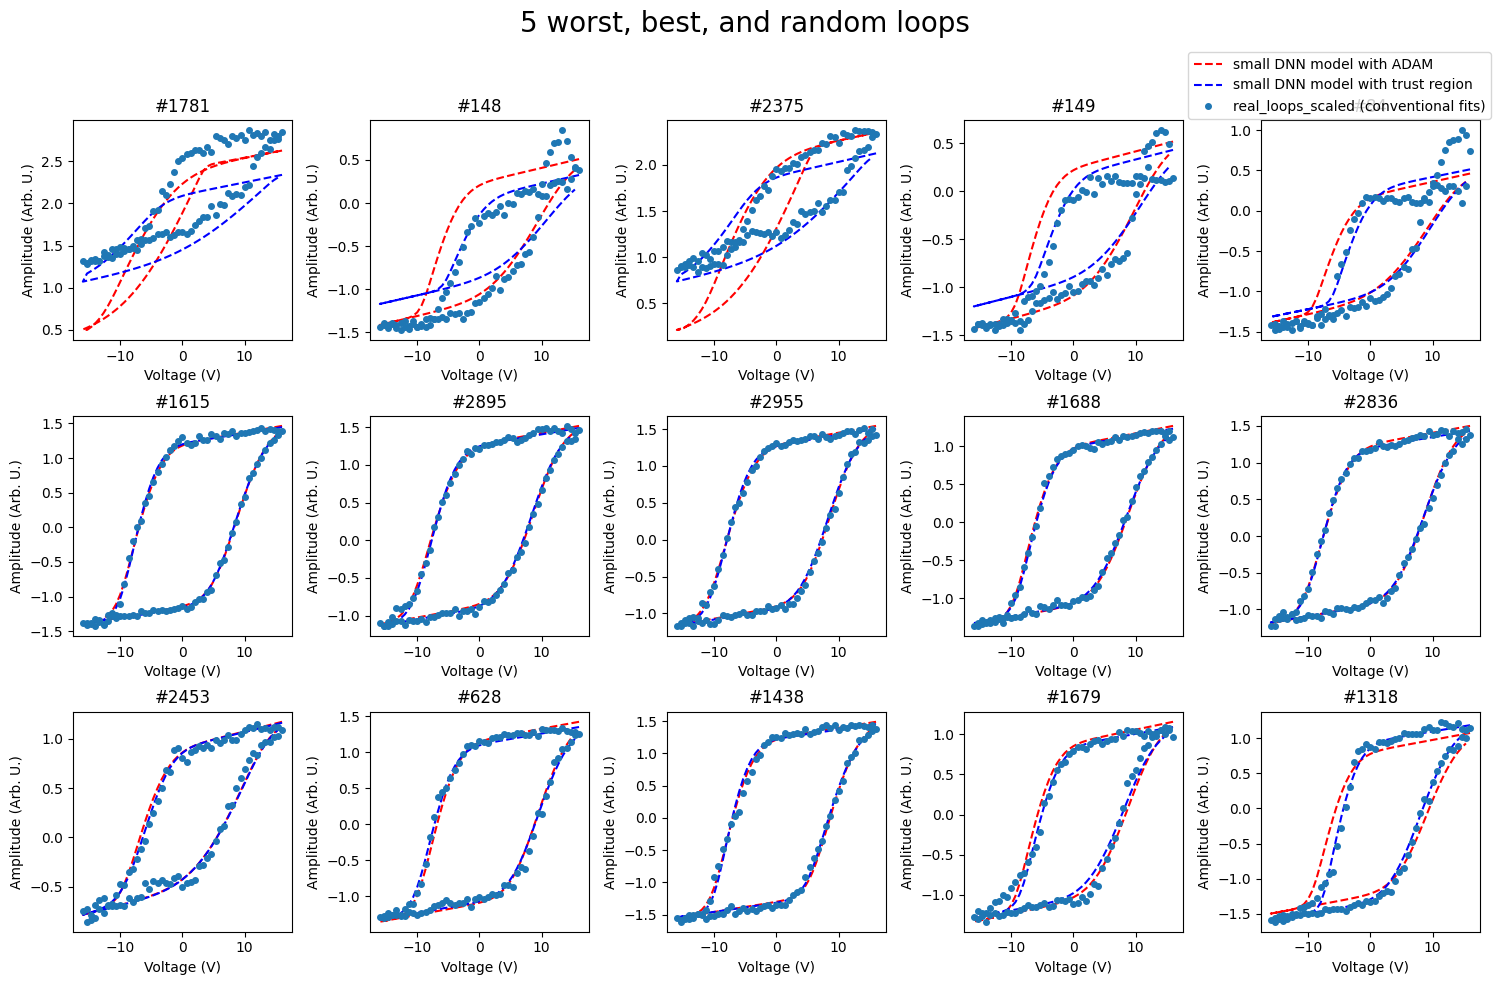

In [15]:
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('5 worst, best, and random loops', fontsize=20)

i = 0
for x in highest:
    axs[0, i].plot(V, scaled_loops_DNN[x],
                    'r--', label='small DNN model with ADAM')
    axs[0, i].plot(V, scaled_loops_DNN_trust[x], 'b--',
                    label='small DNN model with trust region')
    axs[0, i].plot(V, real_scaled_loops[x], 'o', markersize=4,
                    label='real_loops_scaled (conventional fits)')
    axs[0, i].set_title("#" + str(x))
    axs[0, i].set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
    i += 1

i = 0
for x in lowest:
    axs[1, i].plot(V, scaled_loops_DNN[x],
                    'r--', label='small DNN model with ADAM')
    axs[1, i].plot(V, scaled_loops_DNN_trust[x], 'b--',
                    label='small DNN model with trust region')
    axs[1, i].plot(V, real_scaled_loops[x], 'o', markersize=4,
                    label='real_loops_scaled (conventional fits)')
    axs[1, i].set_title("#" + str(x))
    axs[1, i].set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
    i += 1

for i in range(5):
    j = np.random.randint(0, num_pix)
    axs[2, i].plot(V, scaled_loops_DNN[j],
                    'r--', label='small DNN model with ADAM')
    axs[2, i].plot(V, scaled_loops_DNN_trust[j], 'b--',
                    label='small DNN model with trust region')
    axs[2, i].plot(V, real_scaled_loops[j], 'o', markersize=4,
                    label='real_loops_scaled (conventional fits)')
    axs[2, i].set_title("#" + str(j))
    axs[2, i].set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 4.0), loc='upper right', borderaxespad=0.)
fig.subplots_adjust(top=0.87)

plt.savefig('Assets/Figures/best_and_worst_5_min_hysteresis.png', bbox_inches='tight')
plt.savefig('Assets/Figures/best_and_worst_5_min_hysteresis.svg', bbox_inches='tight')

### Visualizes best, worst, and medium results

In [16]:
# getting real loops and scaling
unscaled_loops_lsqf = loop_fitting_function_tf(func_type, V, params)
scaled_loops_lsqf = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, params), \
                            tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))

# printing resulted MSEs
mse_loops_trust = np.mean(np.square((scaled_loops_DNN_trust - real_scaled_loops)), 1)
mse_loops_adam = np.mean(np.square((scaled_loops_DNN - real_scaled_loops)), 1)
mse_loops_lsqf = np.mean(np.square((scaled_loops_lsqf - real_scaled_loops)), 1)
highest_loops_trust = (-mse_loops_trust).argsort()[:]
highest_loops_adam = (-mse_loops_adam).argsort()[:]
highest_loops_lsqf = (-mse_loops_lsqf).argsort()[:]
print('MSE of hysteresis loops with Trust Region CG: ' + str(np.mean(mse_loops_trust)))
print('MSE of hysteresis loops with Adam: ' + str(np.mean(mse_loops_adam)))
print('MSE of hysteresis loops with LSQF: ' + str(np.mean(mse_loops_lsqf)))

MSE of hysteresis loops with Trust Region CG: 0.006134388614062397
MSE of hysteresis loops with Adam: 0.010115672802299587
MSE of hysteresis loops with LSQF: 0.008518574535768287


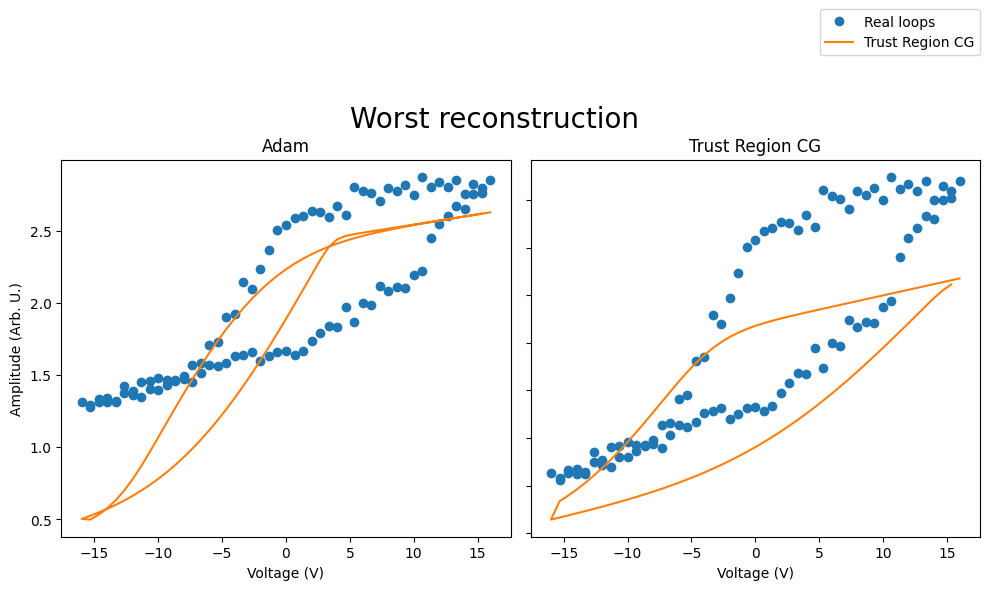

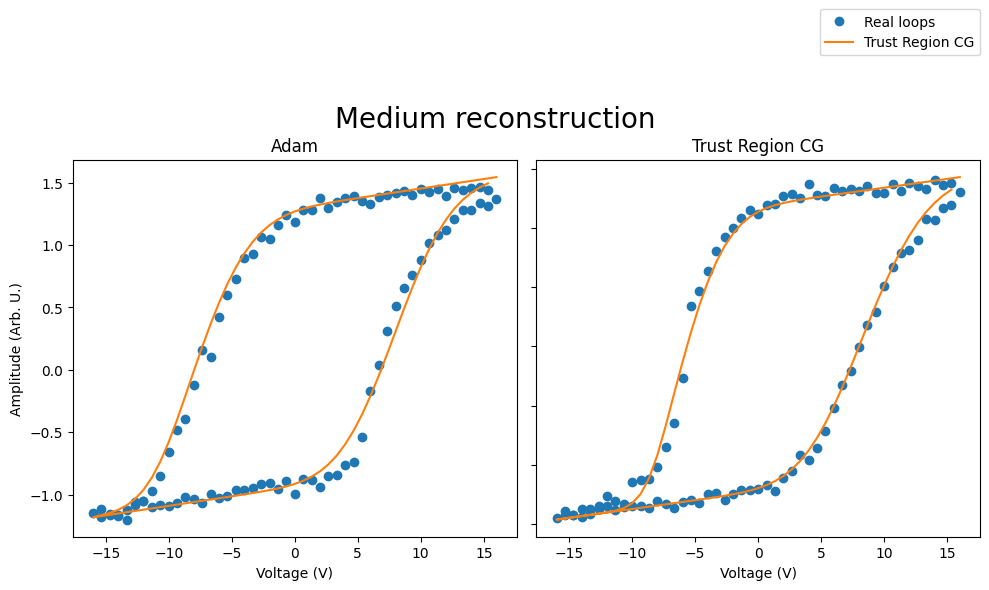

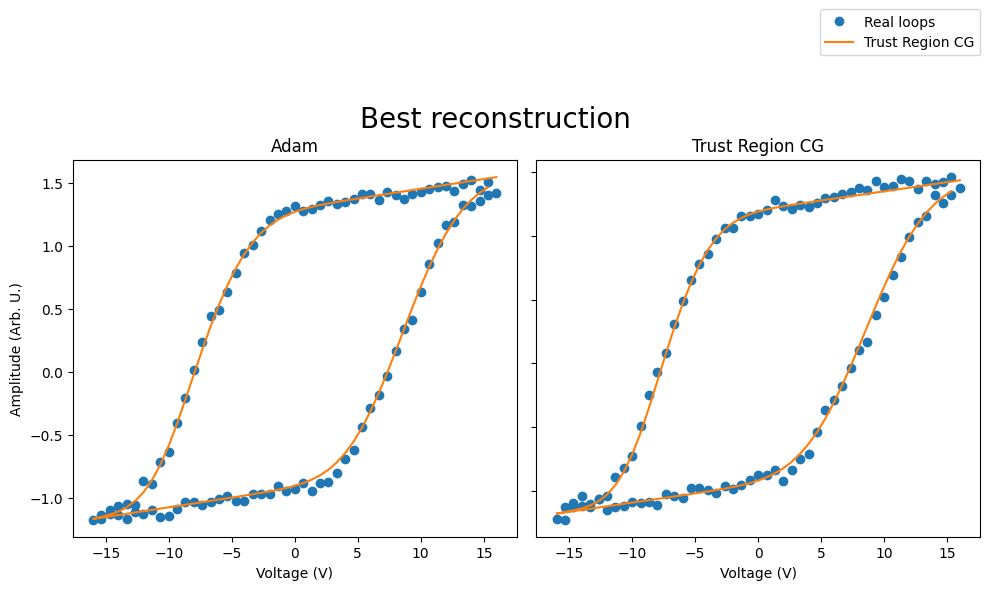

In [18]:
loops_to_plot_idx = [0, real_scaled_loops.shape[0] // 2, -1]
names = ['Worst', 'Medium', 'Best']

for i, idx in enumerate(loops_to_plot_idx):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(names[i] + ' reconstruction', fontsize=20)

    axs[0].set_title('Adam')
    axs[0].plot(V, real_scaled_loops[highest_loops_adam[idx], :], 'o', label='Real loops')
    axs[0].plot(V, scaled_loops_DNN[highest_loops_adam[idx], :], label='LSQF method')

    axs[1].set_title('Trust Region CG')
    axs[1].plot(V, real_scaled_loops[highest_loops_trust[idx], :], 'o', label='Real loops')
    axs[1].plot(V, scaled_loops_DNN_trust[highest_loops_trust[idx], :], label='Trust Region CG')

    for ax in axs.flat:
        ax.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')

    for ax in axs.flat:
        ax.label_outer()

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.00, 1.4), loc='upper right', borderaxespad=0.)
    fig.subplots_adjust(top=0.87)

### Visualizes the distribution of parameters in the form of violin plots

In [21]:
scaled_params_trust = np.divide(np.subtract(unscaled_param_trust, params_mean), params_std)

# converting data to Pandas DataFrame to plot violin plots
df_to_plot = pd.DataFrame(np.vstack((scaled_params_trust, real_parms_scaled)))
df_to_plot = df_to_plot.melt(var_name='Params', value_name='Normalized Params')
df_to_plot['Fit Type'] = 'LSQF'

for i in range(0,18,2):
  df_to_plot.loc[i*scaled_params_trust.shape[0]:(i+1)*real_parms_scaled.shape[0], 'Fit Type'] = 'NN (Trust Region CG)'

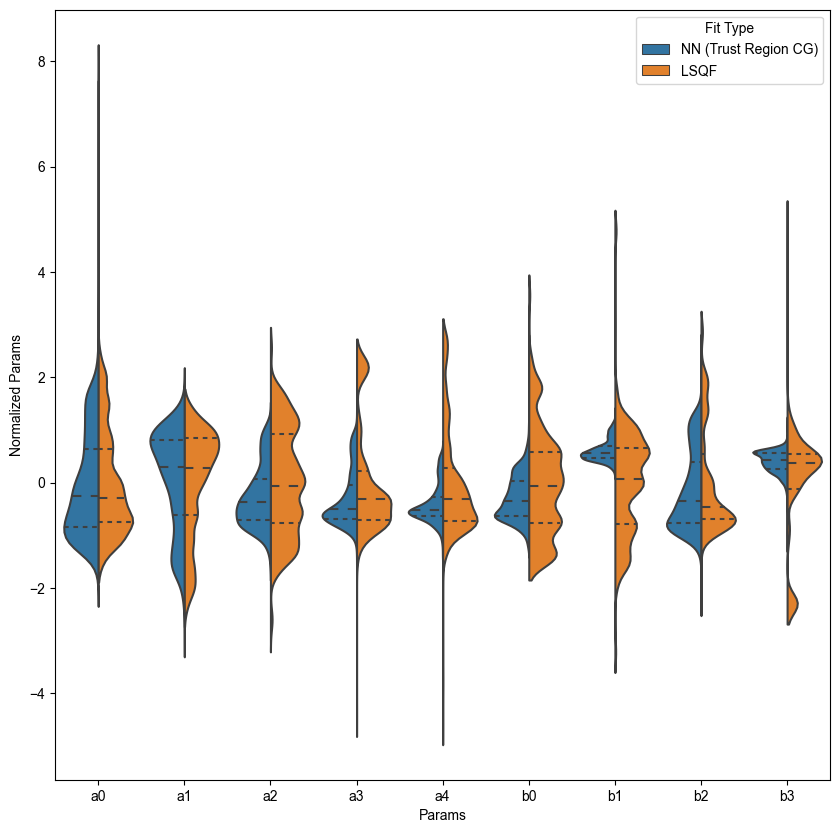

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

labels = ['a0', 'a1', 'a2', 'a3', 'a4', 'b0', 'b1', 'b2', 'b3']

sns.violinplot(x='Params', y='Normalized Params', hue='Fit Type', data=df_to_plot, ax=axs, scale='count', split=True, inner='quartile')
axs.set_xticklabels(labels);
sns.set_theme(style='whitegrid')

plt.savefig('Assets/Figures/violin_hysteresis_params.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/violin_hysteresis_params.svg', bbox_inches='tight', pad_inches=1)

### Visualizes plots with bad distributions

In [25]:
# finding loop indices where params have bad distributions
bad_mse_a2_idx_1 = np.where(real_parms_scaled[:, 2] >= 1)
bad_mse_a2_idx_1 = np.asarray(bad_mse_a2_idx_1[0][:])

bad_mse_a2_idx_2 = np.where((real_parms_scaled[:, 2] < 1) & (real_parms_scaled[:, 2] >= 0))
bad_mse_a2_idx_2 = np.asarray(bad_mse_a2_idx_2[0][:])

bad_mse_a2_idx_3 = np.where((real_parms_scaled[:, 2] < 0) & (real_parms_scaled[:, 2] >= -1))
bad_mse_a2_idx_3 = np.asarray(bad_mse_a2_idx_3[0][:])

bad_mse_a2_idx_4 = np.where(real_parms_scaled[:, 2] < -1)
bad_mse_a2_idx_4 = np.asarray(bad_mse_a2_idx_4[0][:])

bad_mse_a3_idx_1 = np.where(real_parms_scaled[:, 3] >= 2)
bad_mse_a3_idx_1 = np.asarray(bad_mse_a3_idx_1[0][:])

bad_mse_a3_idx_2 = np.where((real_parms_scaled[:, 3] < 2) & (real_parms_scaled[:, 3] >= 1))
bad_mse_a3_idx_2 = np.asarray(bad_mse_a3_idx_2[0][:])

bad_mse_a4_idx = np.where(real_parms_scaled[:, 3] > 0.5)
bad_mse_a4_idx = np.asarray(bad_mse_a4_idx[0][:])

bad_mse_b1_idx = np.where(real_parms_scaled[:, 6] < -0.25)
bad_mse_b1_idx = np.asarray(bad_mse_b1_idx[0][:])

bad_mse_b2_idx_1 = np.where(real_parms_scaled[:, 7] >= 2)
bad_mse_b2_idx_1 = np.asarray(bad_mse_b2_idx_1[0][:])

bad_mse_b3_idx_1 = np.where(real_parms_scaled[:, 8] < -2)
bad_mse_b3_idx_1 = np.asarray(bad_mse_b3_idx_1[0][:])

bad_mse_b3_idx_2 = np.where((real_parms_scaled[:, 8] >= -2) & (real_parms_scaled[:, 8] < -1))
bad_mse_b3_idx_2 = np.asarray(bad_mse_b3_idx_2[0][:])

In [27]:
bad_mse_array = np.array([bad_mse_a2_idx_1, bad_mse_a2_idx_2, bad_mse_a2_idx_3, bad_mse_a2_idx_4,
                         bad_mse_a3_idx_1, bad_mse_a3_idx_2, bad_mse_a4_idx, bad_mse_b1_idx,
                         bad_mse_b2_idx_1, bad_mse_b3_idx_1, bad_mse_b3_idx_2])

good_mse_a3_idx = np.asarray(np.where(real_parms_scaled[:, 3] < 1)[0][:])
good_mse_a4_idx = np.asarray(np.where(real_parms_scaled[:, 4] <= 0.5)[0][:])
good_mse_b1_idx = np.asarray(np.where(real_parms_scaled[:, 6] >= -0.25)[0][:])
good_mse_b2_idx = np.asarray(np.where(real_parms_scaled[:, 7] < 2)[0][:])
good_mse_b3_idx = np.asarray(np.where(real_parms_scaled[:, 8] >= -1)[0][:])

print(f'MSE b3: {(np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_b3_idx_1) - np.take(scaled_loops_lsqf, bad_mse_b3_idx_1)))+np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_b3_idx_2) - np.take(scaled_loops_lsqf, bad_mse_b3_idx_2))))/2}')
print(f'MSE a3: {(np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_a3_idx_1) - np.take(scaled_loops_lsqf, bad_mse_a3_idx_1)))+np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_a3_idx_2) - np.take(scaled_loops_lsqf, bad_mse_a3_idx_2))))/2}')
print(f'MSE b2: {np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_b2_idx_1) - np.take(scaled_loops_lsqf, bad_mse_b2_idx_1)))}')
print(f'MSE a4: {np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_a4_idx) - np.take(scaled_loops_lsqf, bad_mse_a4_idx)))}')
print(f'MSE b1: {np.mean(np.square(np.take(scaled_loops_DNN_trust, bad_mse_b1_idx) - np.take(scaled_loops_lsqf, bad_mse_b1_idx)))}')

MSE b3: 0.009630249702164447
MSE a3: 0.00790041775034115
MSE b2: 0.007475151167621473
MSE a4: 0.00756518579702956
MSE b1: 0.006927327663422298


C:\Users\abeke\AppData\Local\Temp\ipykernel_19572\2666673482.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bad_mse_array = np.array([bad_mse_a2_idx_1, bad_mse_a2_idx_2, bad_mse_a2_idx_3, bad_mse_a2_idx_4,


In [28]:
yLims = [(1, 2.5), (0, 1), (-1, 0), (-2.5, -1), (2, 3), (1, 2), (0.5, 4), (-3, -0.25), (2, 3), (-2.5, -2), (-2, -1)]
bad_param_names = ['a2', 'a2', 'a2', 'a2', 'a3', 'a3', 'a4', 'b1', 'b2', 'b3', 'b3']
param_num = [2, 2, 2, 2, 3, 3, 4, 6, 7, 8, 8]
coordinates = [(0, 1, 2, 2), (0, 0, 2, 1), (0, -1, 2, 1), (0, -3, 2, 2), 
               (0, 2, 3, 1), (0, 1, 2, 1),
               (0, 1, 2, 3),
               (0, -3, 2, 3), 
               (0, 2, 2, 1),
               (0, -1, 2, 1), (0, -3, 2, 2)]

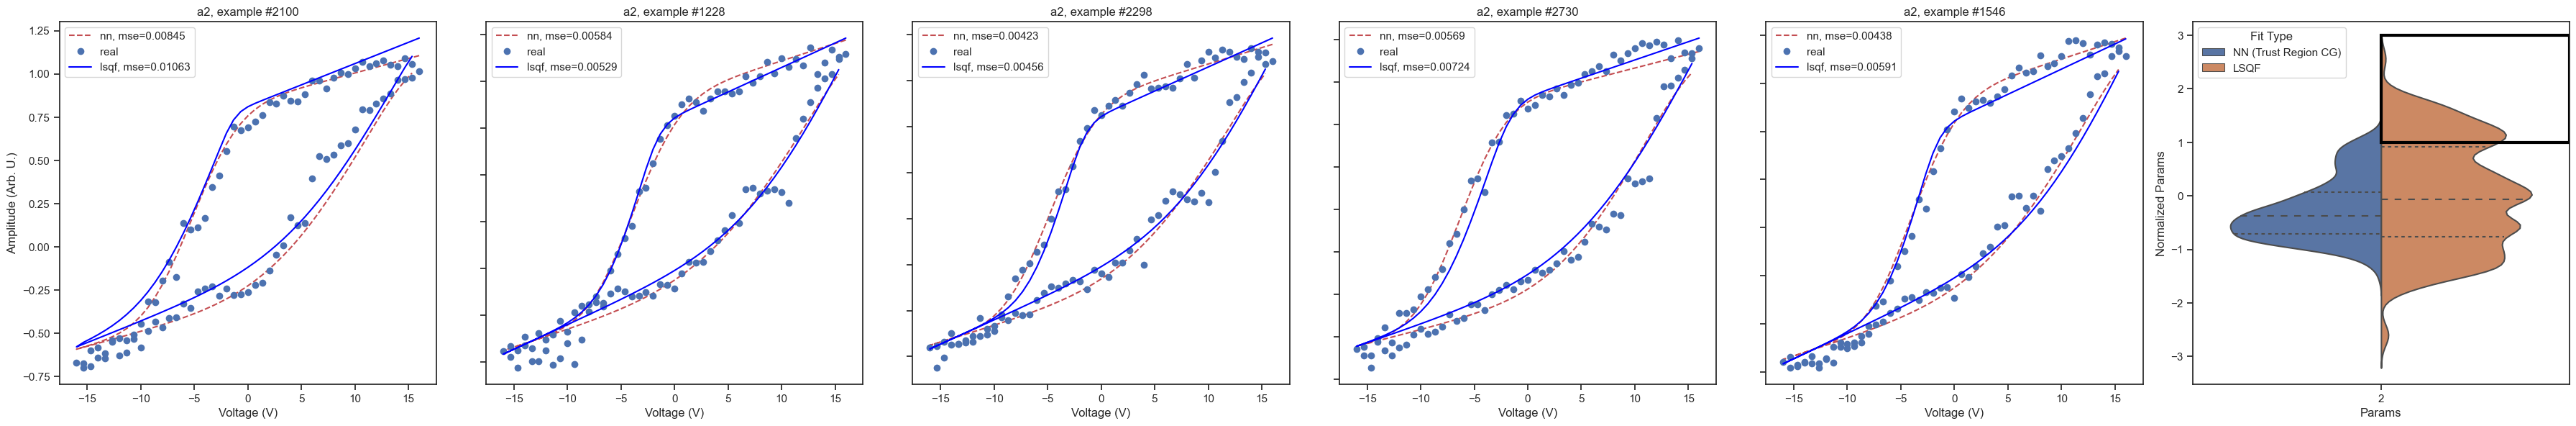

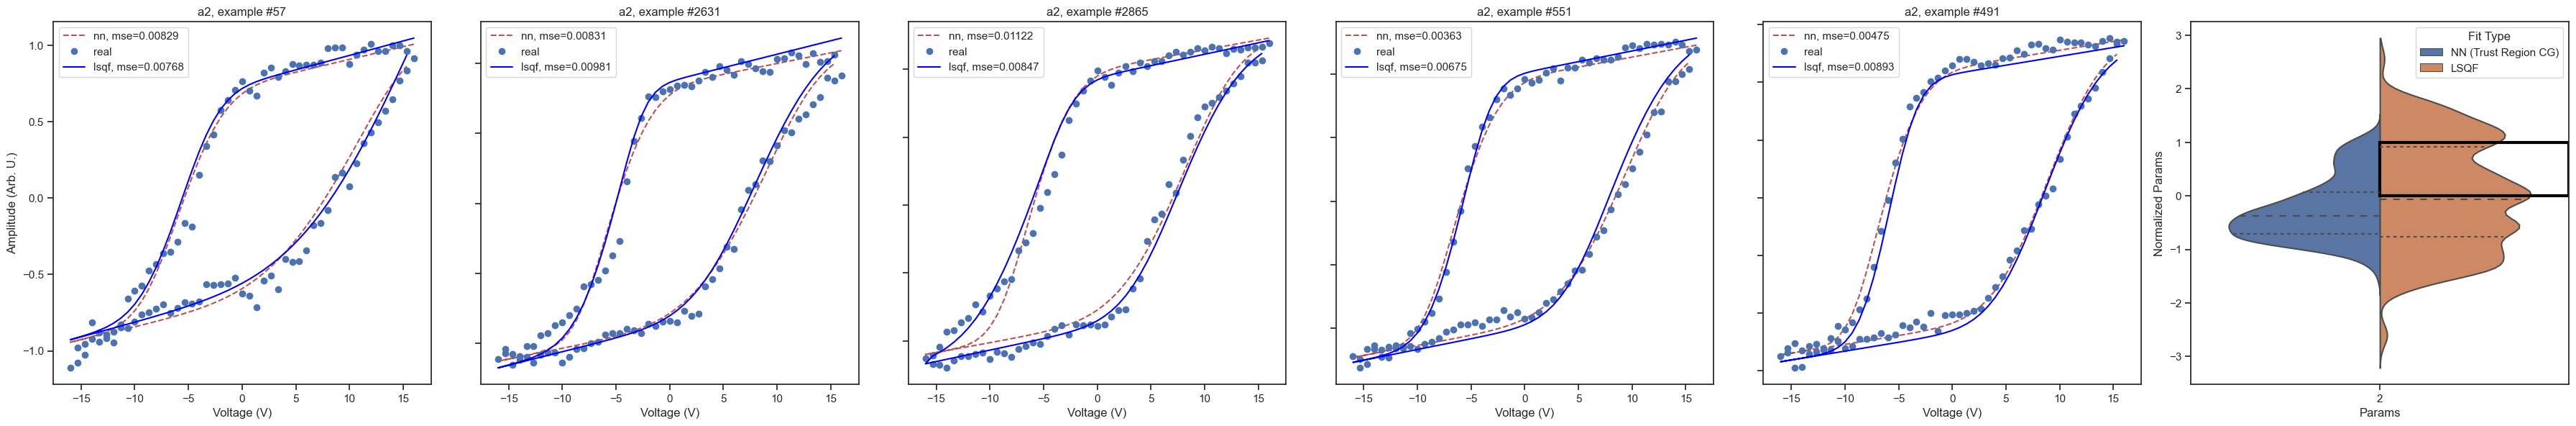

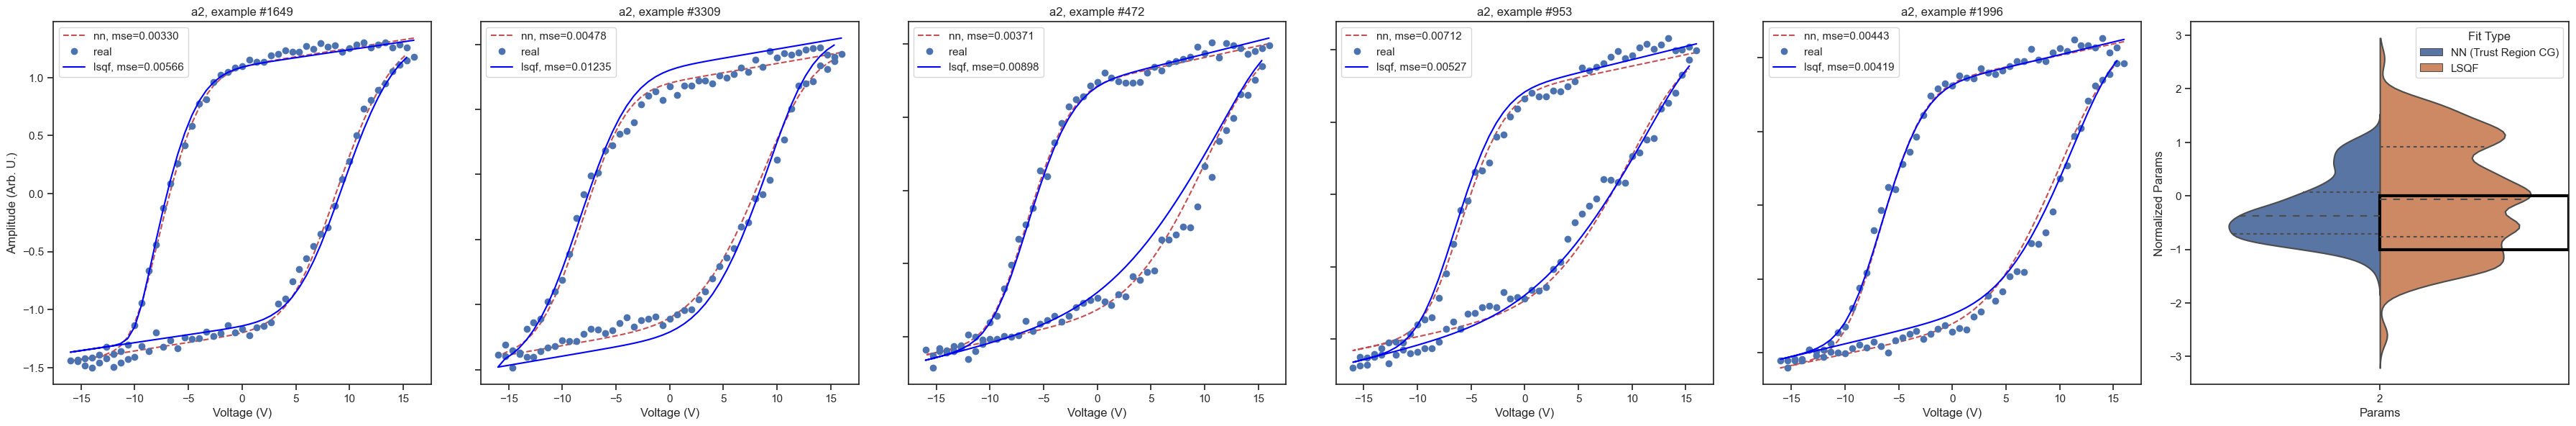

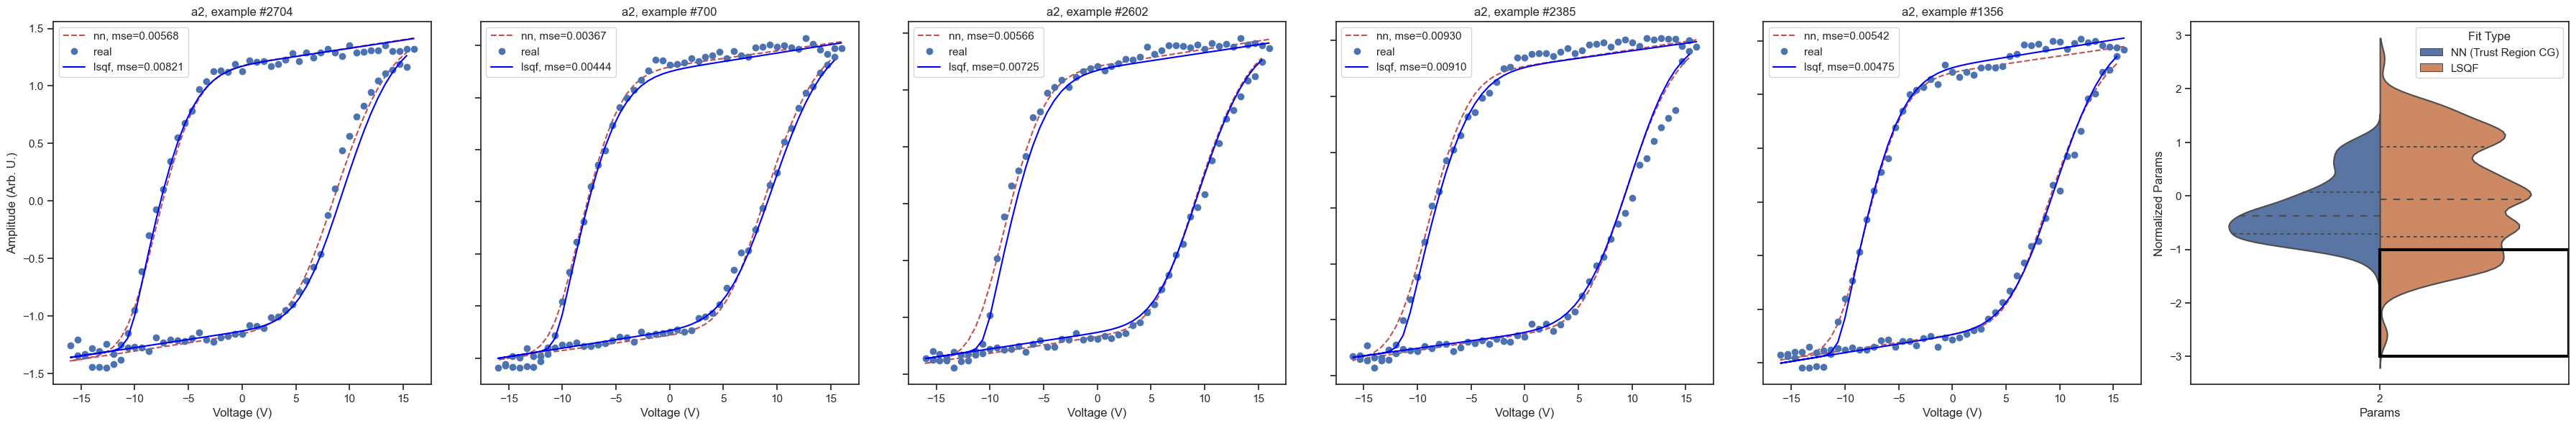

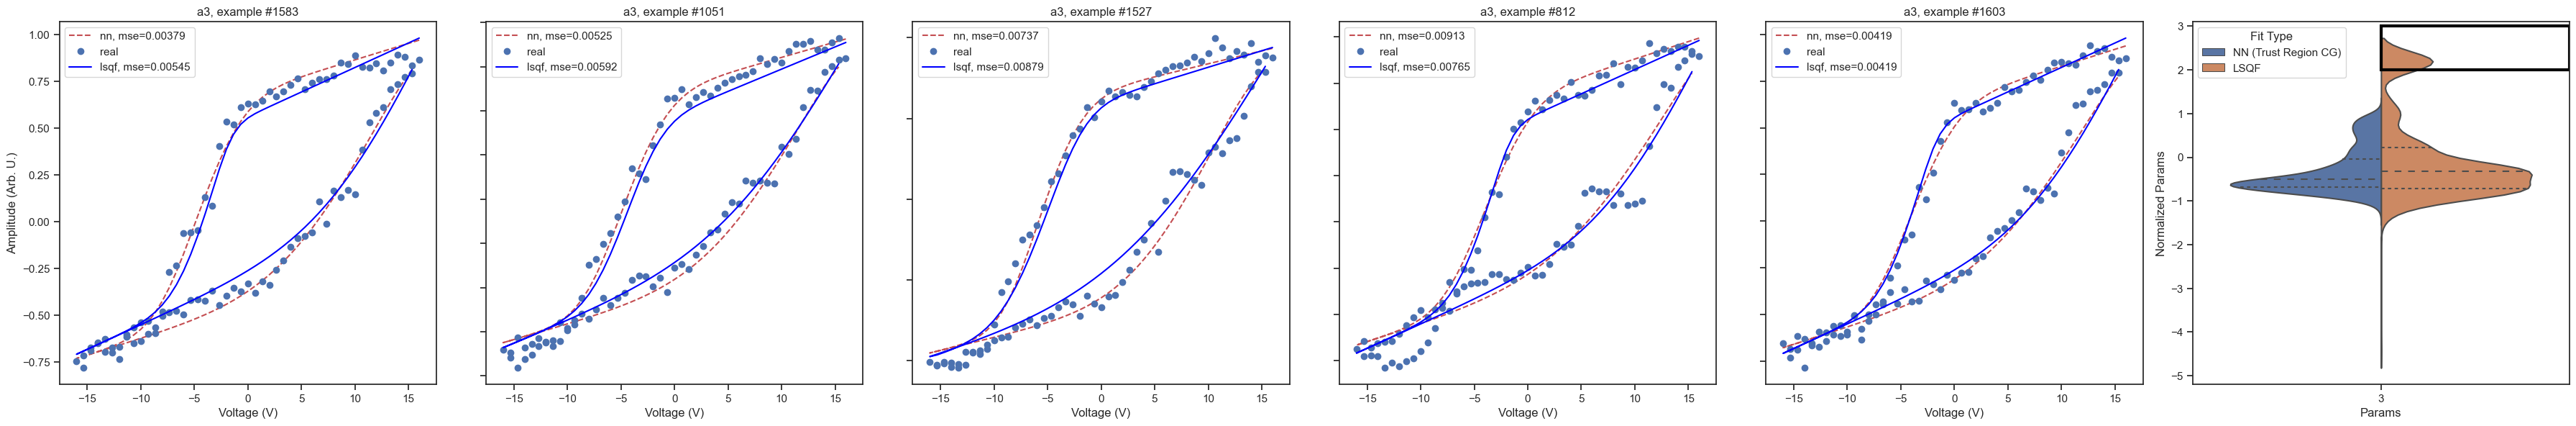

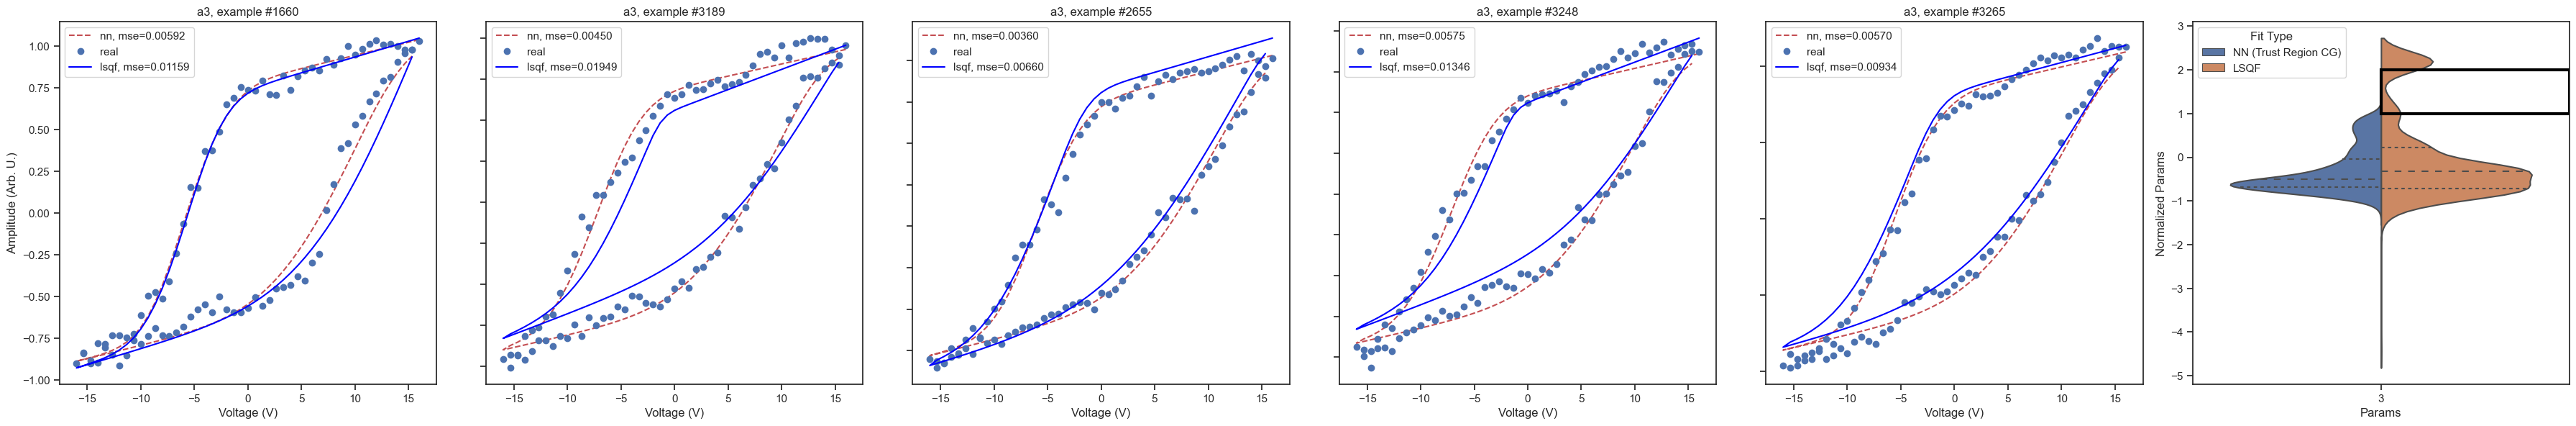

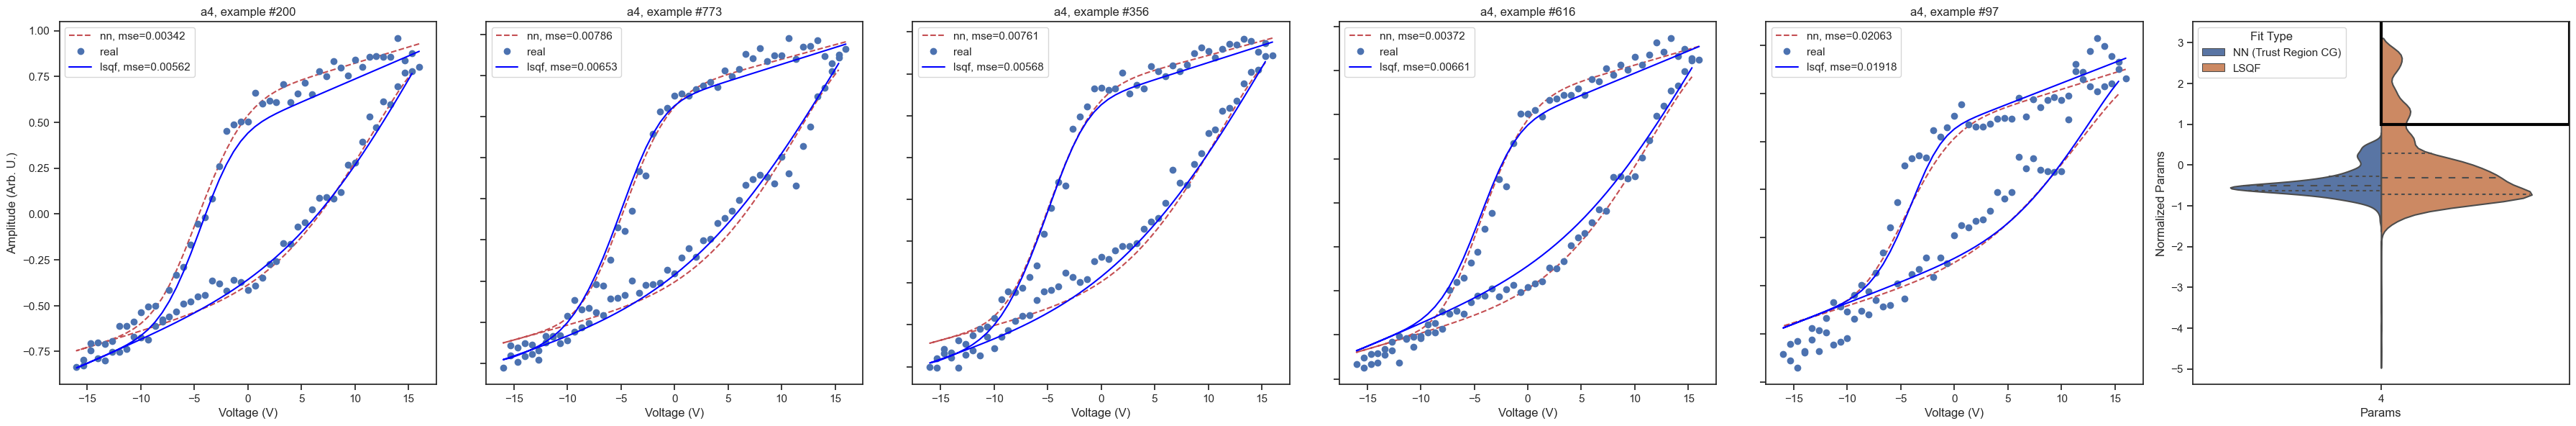

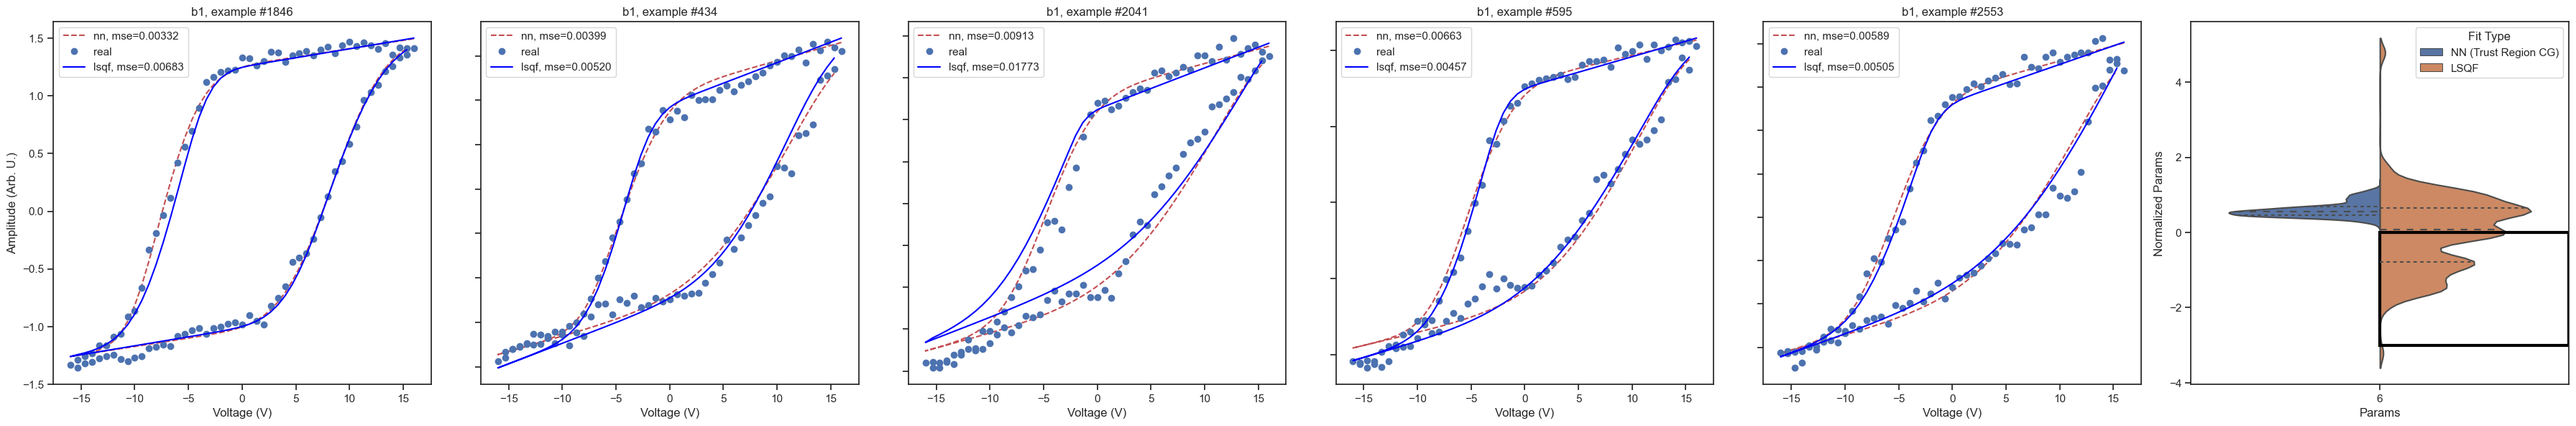

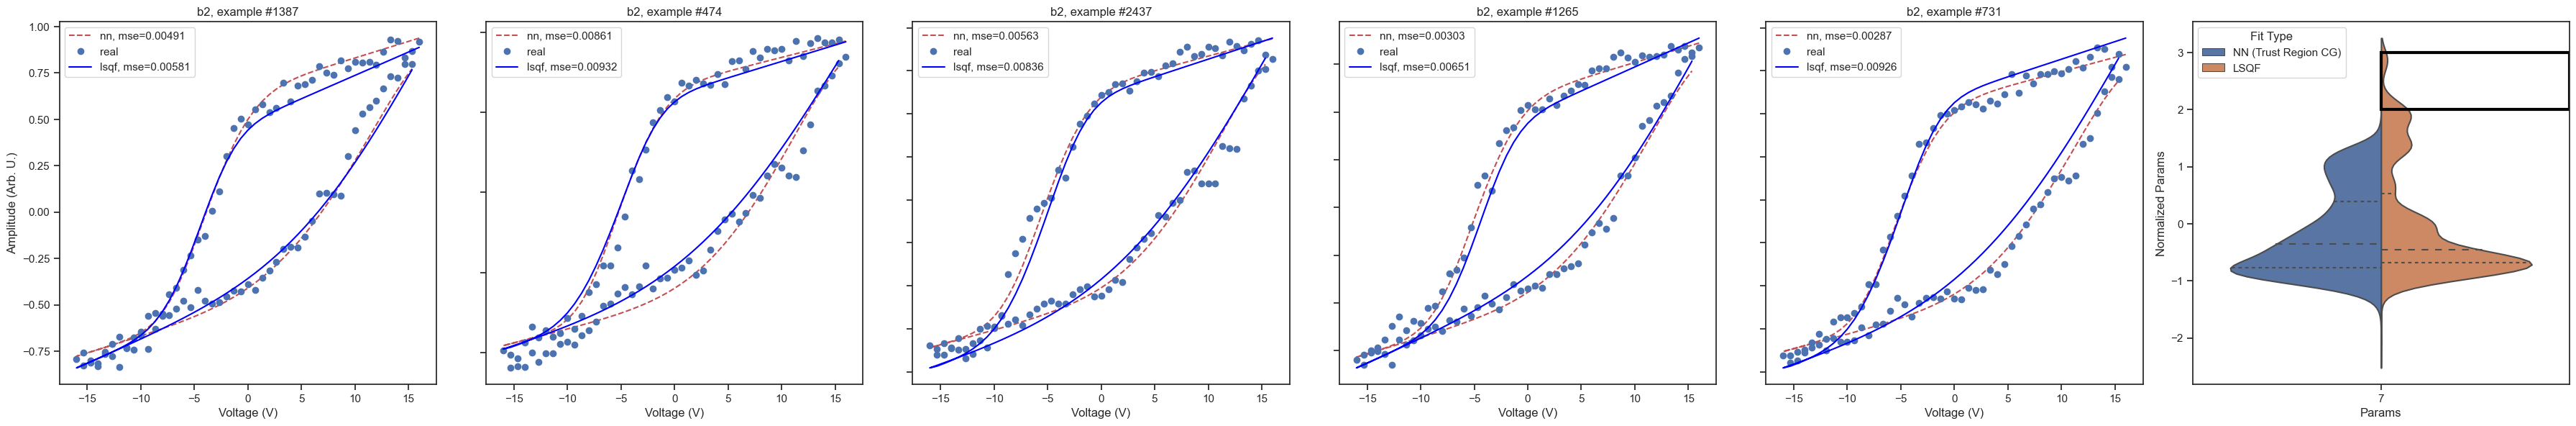

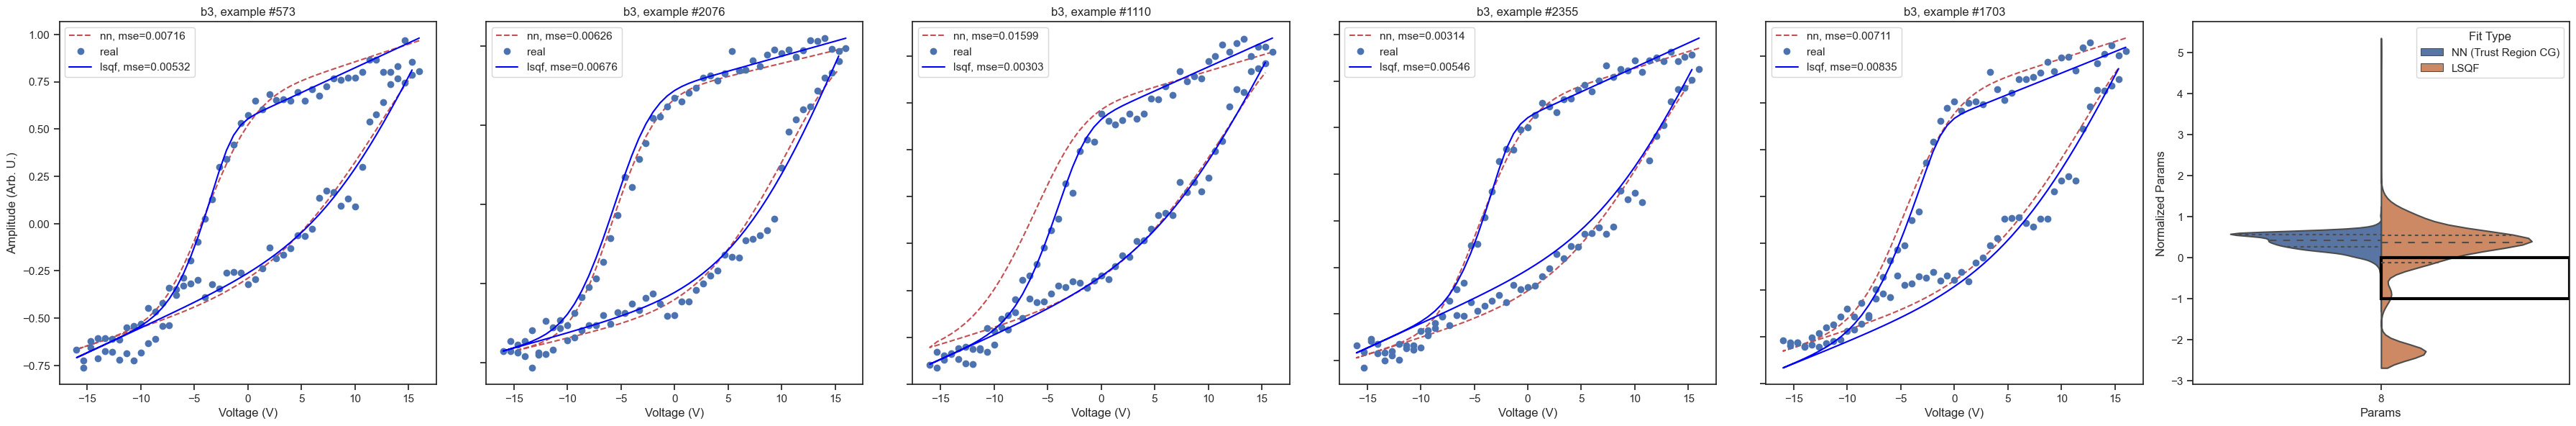

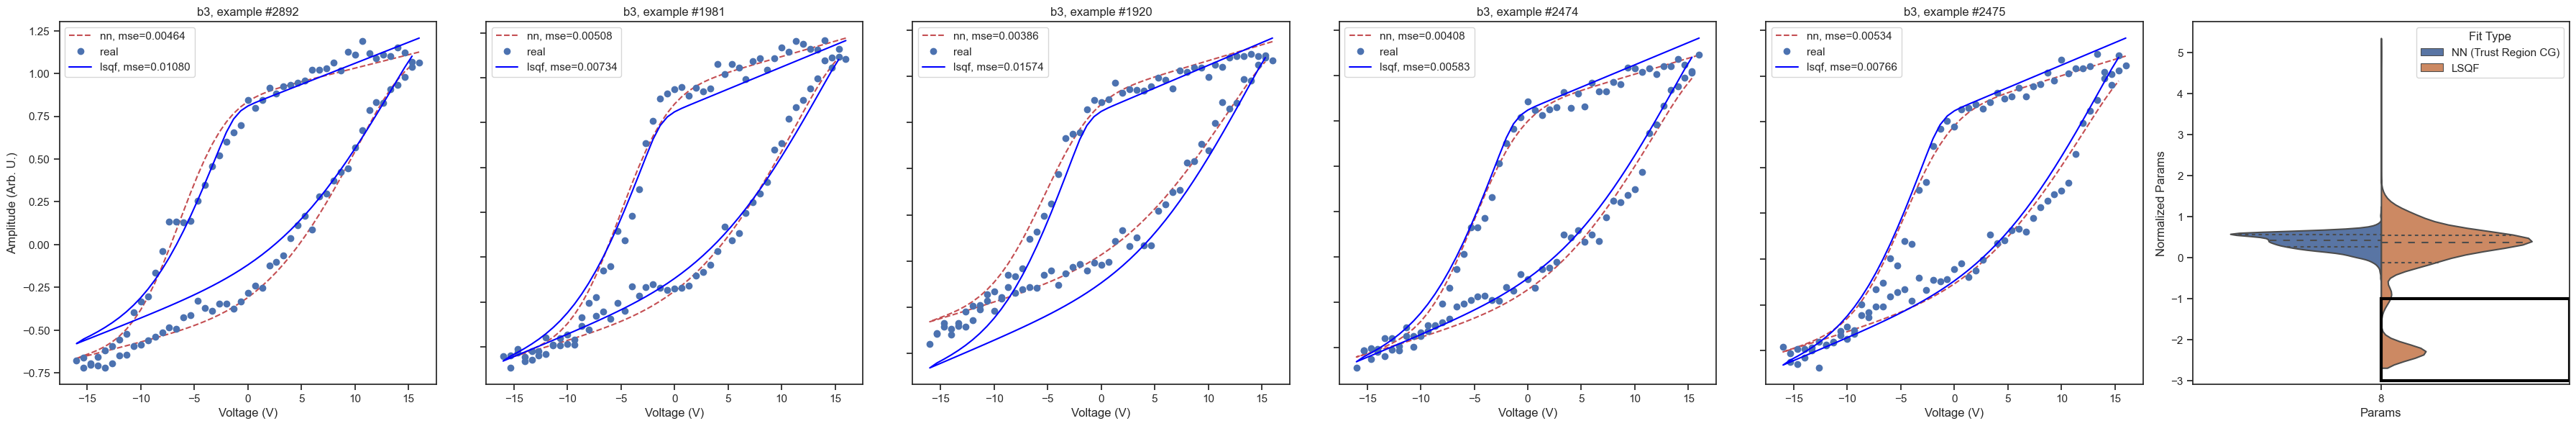

In [32]:
for j in range(len(yLims)):

    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(36, 6))
    # plt.suptitle('Loops with bad parameter distributions', fontsize=20)

    for y in range(5):
        i = np.random.randint(0, bad_mse_array[j].shape[0])
        mse_bad_loop_nn = mean_squared_error(scaled_loops_DNN_trust[bad_mse_array[j][i]], real_scaled_loops[bad_mse_array[j][i]])
        mse_bad_loop_lsqf = mean_squared_error(scaled_loops_lsqf[bad_mse_array[j][i]], real_scaled_loops[bad_mse_array[j][i]])
        axs[y].plot(V, scaled_loops_DNN_trust[bad_mse_array[j][i]],'r--', label=f'nn, mse={mse_bad_loop_nn:.5f}')
        axs[y].plot(V, real_scaled_loops[bad_mse_array[j][i]],'o', label='real', markersize=6)
        axs[y].plot(V, scaled_loops_lsqf[bad_mse_array[j][i]], 'blue', label=f'lsqf, mse={mse_bad_loop_lsqf:.5f}')
        axs[y].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[y].set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)');
        axs[y].set_title(f'{bad_param_names[j]}, example #{bad_mse_array[j][i]}')
        axs[y].legend(loc='upper left')
        axs[y].label_outer()
        axs[y].grid(False)

    sns.set_style("ticks")
    sns.violinplot(x='Params', y='Normalized Params', hue='Fit Type', data=df_to_plot[df_to_plot['Params'] == param_num[j]], ax=axs[5], scale='count', split=True, inner='quartile')
    axs[5].add_patch(Rectangle((coordinates[j][0], coordinates[j][1]),
                        0.5, coordinates[j][3],
                        fc ='none', 
                        ec ='black',
                        lw = 3))

    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig(f'Assets/Figures/hysteresis_bad_param_{bad_param_names[j]}_[{yLims[j][0]};{yLims[j][1]}]_lsqf_nn.png', bbox_inches='tight')
    plt.savefig(f'Assets/Figures/hysteresis_bad_param_{bad_param_names[j]}_[{yLims[j][0]};{yLims[j][1]}]_lsqf_nn.svg', bbox_inches='tight')

### Visualization of results using color maps

In [33]:
a0_min = -2.00 * (real_parms_scaler.var_[0] ** 0.5) + real_parms_scaler.mean_[0]
a0_max = 2.00 * (real_parms_scaler.var_[0] ** 0.5) + real_parms_scaler.mean_[0]
a1_min = -2.00 * (real_parms_scaler.var_[1] ** 0.5) + real_parms_scaler.mean_[1]
a1_max = 2.00 * (real_parms_scaler.var_[1] ** 0.5) + real_parms_scaler.mean_[1]
a2_min = -2.00 * (real_parms_scaler.var_[2] ** 0.5) + real_parms_scaler.mean_[2]
a2_max = 2.00 * (real_parms_scaler.var_[2] ** 0.5) + real_parms_scaler.mean_[2]
a3_min = -3.00 * (real_parms_scaler.var_[3] ** 0.5) + real_parms_scaler.mean_[3]
a3_max = 3.00 * (real_parms_scaler.var_[3] ** 0.5) + real_parms_scaler.mean_[3]
a4_min = -1.00 * (real_parms_scaler.var_[4] ** 0.5) + real_parms_scaler.mean_[4]
a4_max = 3.00 * (real_parms_scaler.var_[4] ** 0.5) + real_parms_scaler.mean_[4]
b0_min = -2.00 * (real_parms_scaler.var_[5] ** 0.5) + real_parms_scaler.mean_[5]
b0_max = 3.00 * (real_parms_scaler.var_[5] ** 0.5) + real_parms_scaler.mean_[5]
b1_min = -2.00 * (real_parms_scaler.var_[6] ** 0.5) + real_parms_scaler.mean_[6]
b1_max = 2.00 * (real_parms_scaler.var_[6] ** 0.5) + real_parms_scaler.mean_[6]
b2_min = -2.00 * (real_parms_scaler.var_[7] ** 0.5) + real_parms_scaler.mean_[7]
b2_max = 2.00 * (real_parms_scaler.var_[7] ** 0.5) + real_parms_scaler.mean_[7]
b3_min = -2.00 * (real_parms_scaler.var_[8] ** 0.5) + real_parms_scaler.mean_[8]
b3_max = 2.00 * (real_parms_scaler.var_[8] ** 0.5) + real_parms_scaler.mean_[8]

mins = [a0_min, a1_min, a2_min, a3_min, a4_min, b0_min, b1_min, b2_min, b3_min]
maxs = [a0_max, a1_max, a2_max, a3_max, a4_max, b0_max, b1_max, b2_max, b3_max]

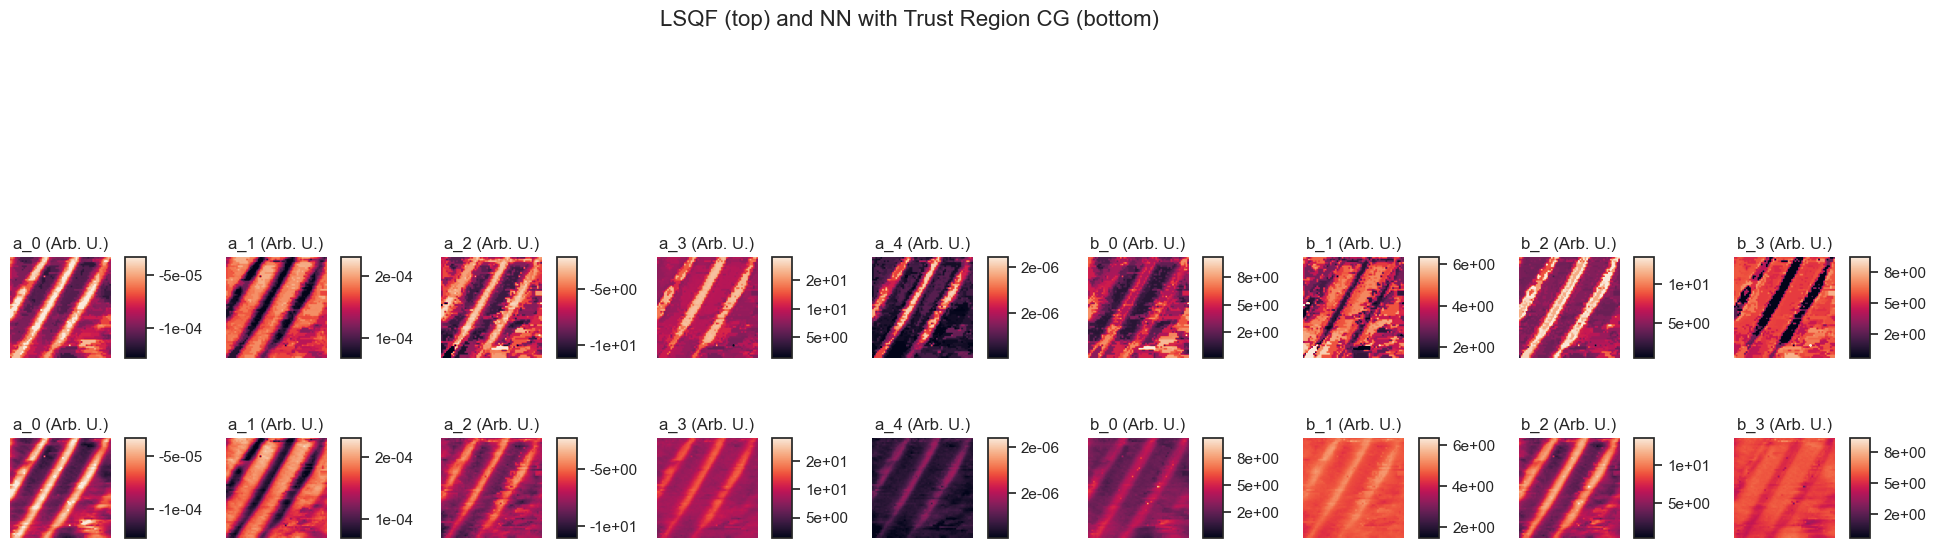

In [36]:
# visualizing results in the form of color maps
fig = plt.figure(figsize=(24., 8.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 9), 
                  cbar_location="right",
                  direction="row",
                  cbar_mode='each',
                  cbar_size="20%",
                  cbar_pad=0.15,
                  axes_pad=0.8,)

for param in range(0, params.shape[1]):
  im1 = grid[param].imshow(params[:, param].reshape(num_pix_1d, num_pix_1d), vmin=mins[param], vmax=maxs[param])
  plt.colorbar(im1, cax=grid[param].cax, format='%.0e')
  grid[param].axis('off')
  grid[param].set_title(params_names[param] + ' (Arb. U.)')

for param in range(0, unscaled_param_trust.shape[1]):
  im1 = grid[param+unscaled_param_trust.shape[1]].imshow(unscaled_param_trust[:, param].reshape(num_pix_1d, num_pix_1d), vmin=mins[param], vmax=maxs[param])
  plt.colorbar(im1, cax=grid[param+unscaled_param_trust.shape[1]].cax, format='%.0e')
  grid[param+unscaled_param_trust.shape[1]].axis('off')
  grid[param+unscaled_param_trust.shape[1]].set_title(params_names[param] + ' (Arb. U.)')

fig.suptitle('LSQF (top) and NN with Trust Region CG (bottom)', fontsize=16);

plt.savefig('Assets/Figures/hysteresis_params_movies_lsqf_nn.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/hysteresis_params_movies_lsqf_nn.svg', bbox_inches='tight', pad_inches=1)